<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [0]:
trainData = torchvision.datasets.FashionMNIST('/content/', train=True, transform=None, target_transform=None, download=True)
testData  = torchvision.datasets.FashionMNIST('/content/', train=False, transform=None, target_transform=None, download=True)


Label      : 9
Dimensions : torch.Size([28, 28])



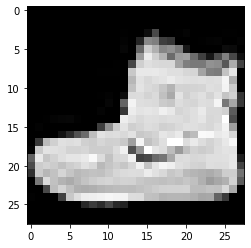

In [4]:
plt.imshow(trainData.train_data[0], cmap='gray')

DIM      = trainData.train_data[0].shape[1]
CHANNELS = 1 if len(trainData.train_data[0].shape) == 2 else trainData.train_data[0].shape[0]
CLASSES  = 10

print(f"""
Label      : {trainData.train_labels[0]}
Dimensions : {trainData.train_data[0].shape}
""")

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 512)
    self.fc2   = nn.Linear(512, CLASSES)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):

    x = self.convs(x)
    x = x.view(-1, self.flatten)
    sm = F.relu(self.fc1(x))
    # x = F.softmax(self.fc2(sm), dim=1)
    x = self.fc2(sm)

    return x, sm

In [0]:
def train(net, train_set, EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):

  x_train, y_train = train_set
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
  loss_func = nn.CrossEntropyLoss()
  loss_log  = []

  for epoch in tqdm(range(EPOCHS)):
    for i in (range(0, len(x_train), BATCH_SIZE)):
        x_batch = x_train[i:i+BATCH_SIZE].view(-1, CHANNELS, DIM, DIM).to(device)
        y_batch = y_train[i:i+BATCH_SIZE].to(device)

        net.zero_grad()
        output, sm = net(x_batch.float())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
    loss_log.append(loss)
    # print(f"Epoch : {epoch} || Loss : {loss}")

  return loss_log


def test(net, test_set):
  x_test, y_test = test_set
  correct = 0
  total   = 0

  with torch.no_grad():
    for i in tqdm(range(len(x_test))):
      real_class = torch.argmax(y_test[i].to(device))
      x = x_test[i].view(-1, CHANNELS, DIM, DIM).to(device)
      pred, sm = net(x.float())
      pred_class = torch.argmax(pred)

      total += 1
      if real_class == pred_class:
        correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Accuracy : {round(accuracy, 2)} %')

100%|██████████| 10000/10000 [00:06<00:00, 1554.40it/s]



Accuracy : 10.88 %


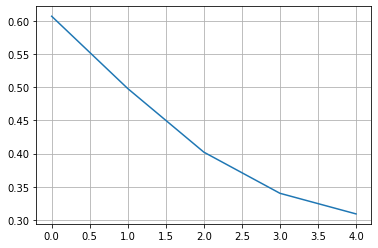

In [100]:
train_set = (trainData.train_data/255.0, trainData.train_labels)
test_set  = (testData.test_data/255.0, testData.test_labels)

EPOCHS        = 5
LEARNING_RATE = 0.0001
BATCH_SIZE    = 16

net = Net().to(device)

loss_log = train(net, train_set, EPOCHS, LEARNING_RATE, BATCH_SIZE)
plt.plot(loss_log)
plt.grid(1)

test(net, test_set)